In [35]:
!pip install -q pyyaml h5py


import tensorflow as tf
from keras.datasets import cifar10,fashion_mnist
# Cargamos las librerías necesarias para la práctica
import keras
from keras import models
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout, MaxPooling2D,UpSampling2D
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
 
from keras.utils import plot_model
from keras.datasets import mnist, cifar10, fashion_mnist
from tqdm import tqdm
from io import BytesIO, StringIO
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image


import numpy as np
import cv2
from PIL import Image

import os, random, re, imageio, time, inspect

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image


In [36]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [37]:
#Realizamos la división de los conjuntos de datos en entrenamiento y test
(x_train_cifar10, _), (x_test_cifar10, _) = cifar10.load_data()


#Este paso lo realizamos ya que las imágenes de CIFAR10 son a color
x_train_cifar10 = x_train_cifar10.astype('float32') / 255
x_test_cifar10 = x_test_cifar10.astype('float32') / 255

#Croppeamos las imágenes
x_train_cifar10 = x_train_cifar10[:, 3:31, 3:31,:]
x_test_cifar10 = x_test_cifar10[:, 3:31, 3:31, :]





In [38]:
def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    z = 0
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()
    


def rgb2gray(data):
    # grayscale = 0.299*red + 0.587*green + 0.114*blue
    factors = [0.299, 0.587, 0.114]
    return np.dot(data[...,:3], factors).reshape(list(data.shape[:-1]) + [1]) 

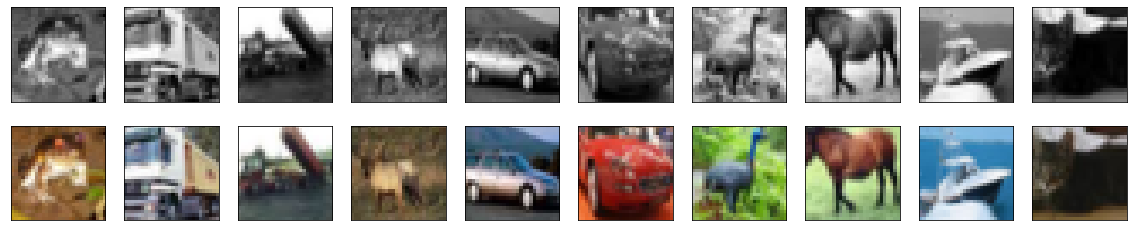

In [39]:

# Pasamos las imágenes a escala de grises
x_train_cifar10_gray = rgb2gray(x_train_cifar10)                    
x_test_cifar10_gray = rgb2gray(x_test_cifar10)


draw2compare(rgb2gray(x_train_cifar10[:10]), x_train_cifar10[:10])

In [40]:
class Autoencoder:
    
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_filters, decoder_conv_kernel_size, decoder_conv_strides, activation, z_dim,
                 use_batch_normalization=False, dropout = None):
    
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides
        self.z_dim = z_dim
        self.activation = activation
        self.use_batch_normalization = use_batch_normalization
        self.dropout = dropout
        
        # Esta parte está modificada para enlazar el codificador y el decodificador
        self.encoder, encoder_input, encoder_output = self.__create_encoder() 
        self.decoder = self.__create_decoder()
        self.model = Model(encoder_input, self.decoder(encoder_output))
        
    def __create_encoder(self):

        encoder_input = Input(shape=self.input_dim, name='encoder_input') 
        x = encoder_input
        for i in range(len(self.encoder_conv_filters)):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernel_size[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                activation = self.activation if isinstance(self.activation, str) else None,
                name = 'encoder_conv_' + str(i)
            )
 
            x = conv_layer(x)
            
            # Si el usuario ha definido una función de activación específica
            # para la última capa la ponemos. Para ver si la ha definido o no usamos
            # inspect. Más información en https://docs.python.org/3/library/inspect.html   
            if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                x = self.activation()(x)
            # Si el usuario ha marcado el uso de BatchNormalization, lo incluimos    
            if self.use_batch_normalization:
                x = BatchNormalization()(x)
            # Si hay Dropout, lo incluimos
            if self.dropout:
                x = Dropout(self.dropout)(x)                

        # Nos guardamos el tamaño antes de aplanar y aplanamos        
        self.__shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        
        encoder_output = self._create_latent_vector(encoder_input, x)
        
        return Model(encoder_input, encoder_output), encoder_input, encoder_output #(5)
        
    def _create_latent_vector(self, encoder_input, x):
        encoder_output= Dense(self.z_dim, name='encoder_output')(x) 
        return encoder_output
    
    
    def __create_decoder(self):
        # La entrada del decodificador es un vector del tamaño
        # que hayamos fijado para el vector latente
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        # Conectamos la entrada a una capa densa con tantas neuronas como
        # entradas tenía la capa correspondiente en el codificador antes de aplanar
        x = Dense(np.prod(self.__shape_before_flattening))(decoder_input)
        # Cambiamos el tamaño de la salida de la capa densa y lo adaptamos 
        # para ser la entrada 2Dde una capa convolutiva
        
        x = Reshape(self.__shape_before_flattening)(x) #(3)
        # Creamos las capas Conv2DTranspose y las apilamos
        for i in range(len(self.decoder_conv_filters)):
            activation = self.activation if isinstance(self.activation, str) else None
            conv_layer = Conv2DTranspose(
                filters = self.decoder_conv_filters[i],
                kernel_size = self.decoder_conv_kernel_size[i],
                strides = self.decoder_conv_strides[i],
                padding = 'same',
                activation = activation if i < len(self.decoder_conv_filters)-1 else 'sigmoid',
                name = 'decoder_conv_' + str(i)
            )
 
            x = conv_layer(x) 
            # De manera análoga a lo que ocurría en el codificador, hacemos las
            # comprobaciones y los cambios si son necesarios
            if i < len(self.decoder_conv_filters)-1:
                if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                    x = self.activation()(x)

                if self.use_batch_normalization:
                    x = BatchNormalization()(x)

                if self.dropout:
                    x = Dropout(self.dropout)(x)                
            
            
        decoder_output = x
        # Finalmente, devolvemos el decodificador que toma como entrada
        # el vector latente y devuelve una imagen del mismo tamaño que las imágenes de entrada
        return Model(decoder_input, decoder_output)

In [41]:
Coloreador = Autoencoder(
    input_dim = (28,28,1)
        , encoder_conv_filters = [28,56,56,56]
        , encoder_conv_kernel_size = [3,3,3,3]
        , encoder_conv_strides = [1,2,2,1]
        , decoder_conv_filters = [64,64,32,3]
        , decoder_conv_kernel_size = [3,3,3,3]         #(2)
        , decoder_conv_strides = [1,2,2,1]
        , activation = 'relu'
        , z_dim = 784)                                

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)   
 

Coloreador.model.compile(optimizer='adam', loss = 'mean_squared_error')

In [42]:
#Coloreador.model.load_weights('/gdrive/My Drive/modelo_coloreador_25_8_2020')

In [43]:
Coloreador.model.fit(x=x_train_cifar10_gray, y=x_train_cifar10, batch_size=128, shuffle=True, epochs=50) 


Epoch 1/50
391/391 [==============================] - 177s 453ms/step - loss: 0.0209
Epoch 2/50
391/391 [==============================] - 177s 452ms/step - loss: 0.0107
Epoch 3/50
391/391 [==============================] - 179s 459ms/step - loss: 0.0091
Epoch 4/50
391/391 [==============================] - 176s 451ms/step - loss: 0.0084
Epoch 5/50
391/391 [==============================] - 177s 452ms/step - loss: 0.0080
Epoch 6/50
391/391 [==============================] - 178s 456ms/step - loss: 0.0077
Epoch 7/50
391/391 [==============================] - 176s 451ms/step - loss: 0.0075
Epoch 8/50
391/391 [==============================] - 176s 451ms/step - loss: 0.0073
Epoch 9/50
391/391 [==============================] - 176s 450ms/step - loss: 0.0071
Epoch 10/50
391/391 [==============================] - 179s 458ms/step - loss: 0.0069
Epoch 11/50
391/391 [==============================] - 177s 452ms/step - loss: 0.0068
Epoch 12/50
391/391 [==============================] - 176s 451

In [44]:
Coloreador.model.save_weights('/gdrive/My Drive/modelo_coloreador_25_8_2020',overwrite=True)

In [45]:
Coloreador.model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 28)        280       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 56)        14168     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 56)          28280     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 56)          28280     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2744)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 784)             

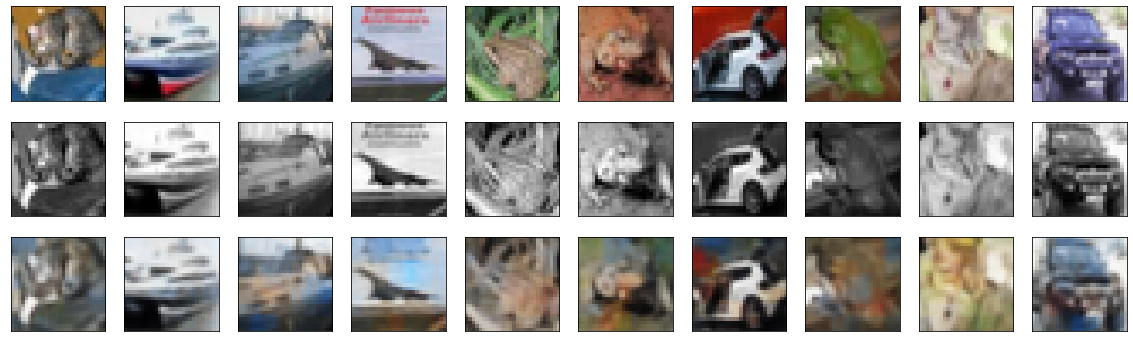

In [46]:
# Comparamos los resultados sobre el conjunto de test

colorized_samples = Coloreador.model.predict(x_test_cifar10_gray)

# Primera fila: Imágenes originales
# Segunda fila: Imágenes originales pasadas a blanco y negro
# Tercera fila: Salida del autoencoder al proporcionale las imágenes en blanco y negro

draw2compare(x_test_cifar10[:10], x_test_cifar10_gray[:10], colorized_samples[:10])

In [47]:
(x_train_fashion_mnist, _), (x_test_fashion_mnist, _) = fashion_mnist.load_data()

x_train_fashion_mnist = x_train_fashion_mnist.astype('float32') / 255
x_test_fashion_mnist = x_test_fashion_mnist.astype('float32') / 255





4423680/4422102 [==============================] - 0s 0us/step


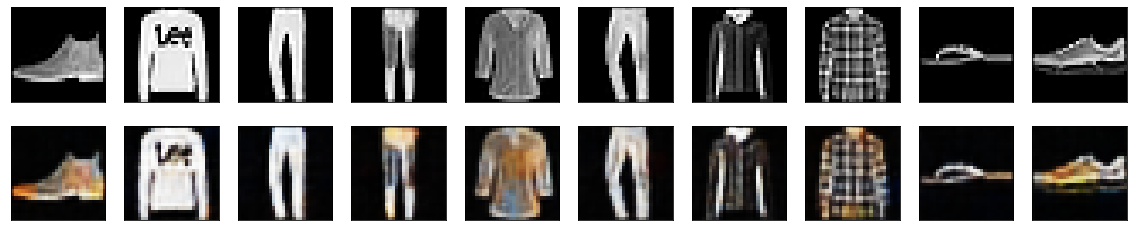

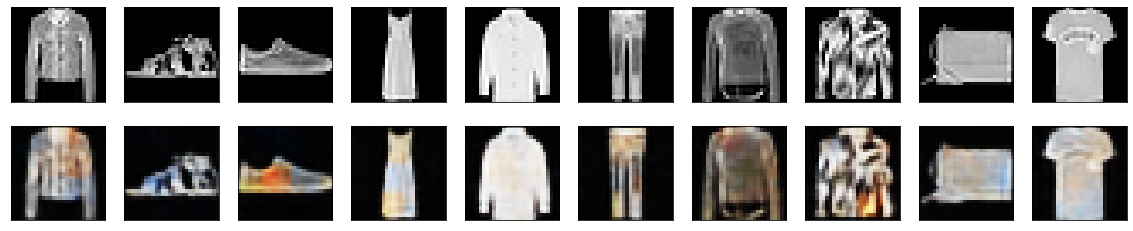

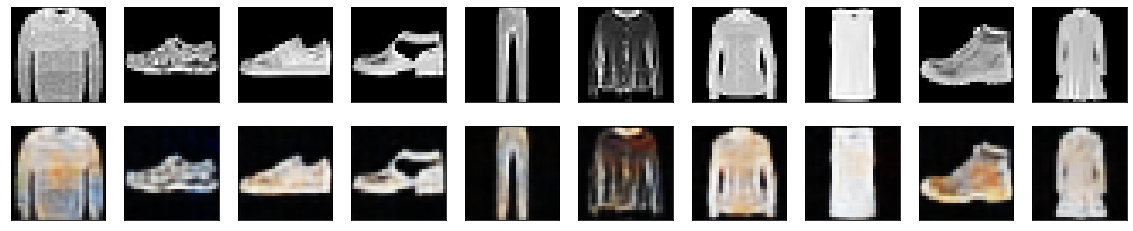

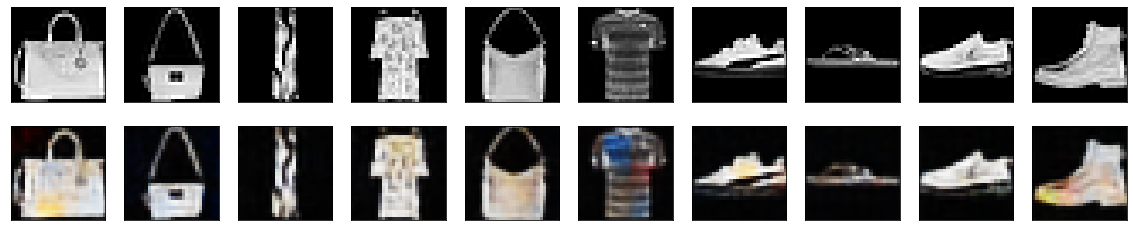

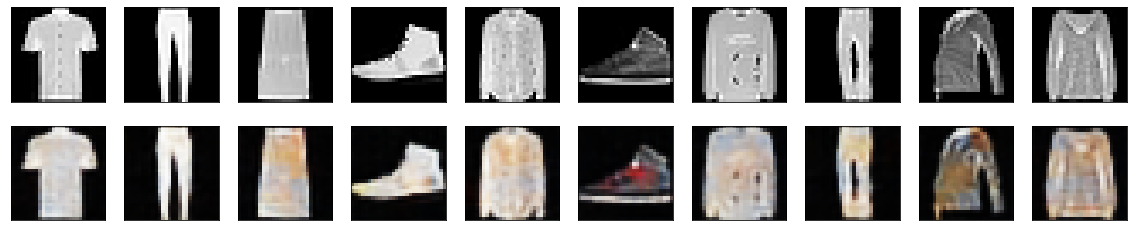

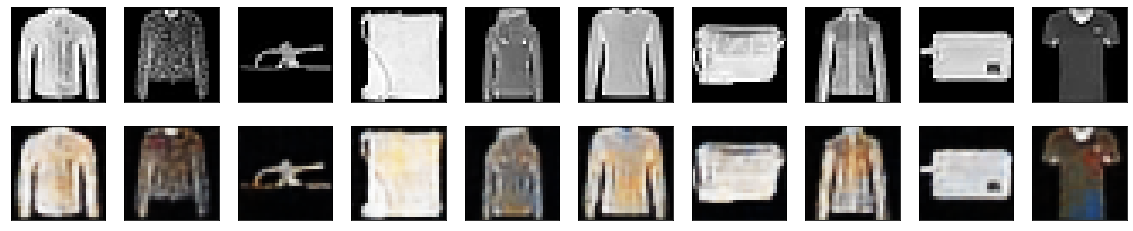

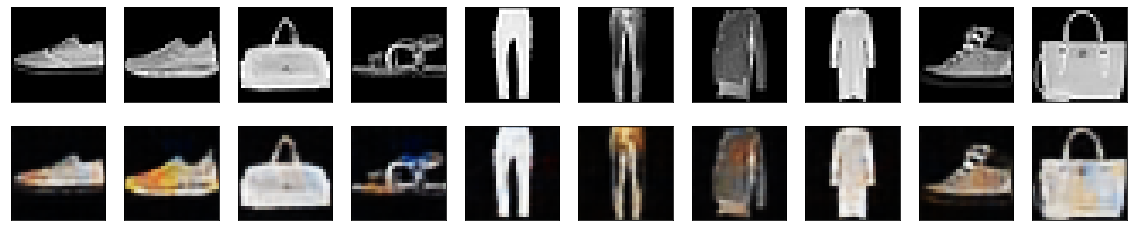

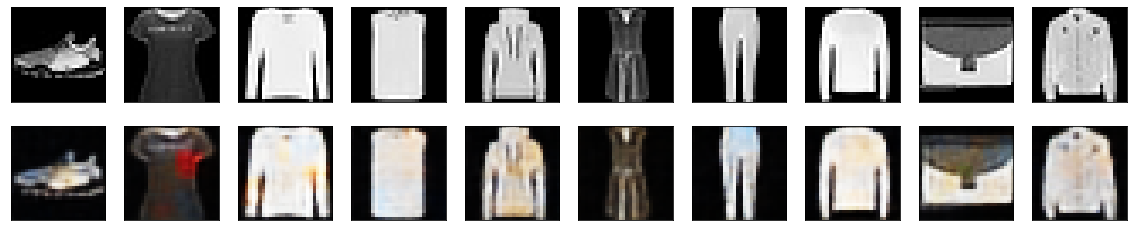

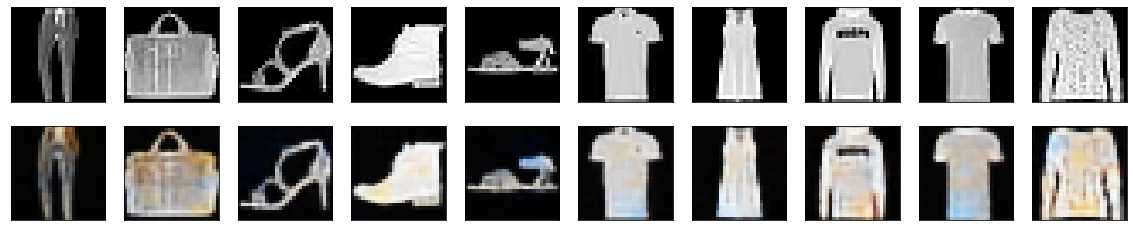

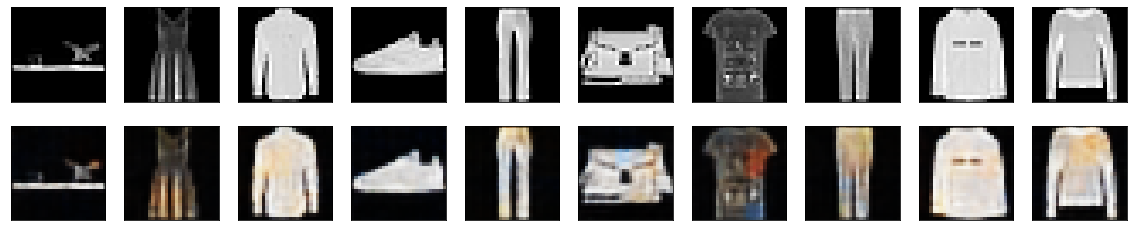

In [48]:


colorized_samples_fashion = Coloreador.model.predict(x_test_fashion_mnist)




# Primera fila: Imágenes originales
# Segunda fila: Imágenes originales pasadas a blanco y negro
# Tercera fila: Salida del autoencoder al proporcionale las imágenes en blanco y negro
for i in [1,2,3,4,5,6,7,8,9,10]:
  draw2compare(x_test_fashion_mnist[10*i-10:10*i], colorized_samples_fashion[10*i-10:10*i])
